In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Need to figure out how to integrate the function

In [3]:
TARGET_RADIUS = 1.5 * 25.4 # mm
TARGET_TILT = 15 * np.pi / 180 # rad
SUBSTRATE_RADIUS = 10 # mm
TARGET_SPIN_RATE = 1 # per second

CHAMBER_VERTICAL = 136
CHAMBER_LATERAL = 0

In [4]:
def cart_to_polar(x, y):

    r = np.sqrt(x**2 + y**2)
    phi = np.arctan(y/x)
    return r, phi

def cylinder_sag(y, RoC):
    return -np.sqrt(RoC**2 - y**2) + RoC

def cylinder_surface_normal(y, RoC):
    denomenator = np.sqrt(RoC**2 - y**2)
    xcomp = np.zeros_like(y)
    ycomp = y / denomenator
    zcomp = np.ones_like(y)

    vec = np.array([xcomp, ycomp, zcomp])

    if vec.ndim > 1:
        for _ in range(vec.ndim - 1):
            vec = np.moveaxis(vec,-1,0)

    return vec

def erosion_profile(a, max_radius):
    return np.sin(a * np.pi / max_radius)

def target_surface_normal(omega):

    xcomp = -np.sin(omega)
    ycomp = 0.
    zcomp = -np.cos(omega)

    return np.array([xcomp, ycomp, zcomp])

def distance_to_target(x, y, a, phi, h, l, omega, zfunc, znorm, RoC, spin_rate, t, spin_offset=0):
    """compute distance from point on target to a point on the substrate

    Parameters
    ----------
    x : float
        cartesian point on the substrate
    y : float
        cartesian point on the substrate
    a : float
        radial point on the target
    phi : float
        azimuthal point on the target
    h : float
        vertical distance from target to substrate
    l : float
        lateral distance from target to substrate
    omega : float
        tilt of the target w.r.t. the horizontal axis
    zfunc : callable
        sag function of the substrate, i.e. sag = zfunc(y, RoC)
    znorm : callable
        surface normal function of the substrate, i.e. normal = znorm(y, RoC)
    RoC : float
        Radius of curvature of the substrate
    spin_rate : float
        angular frequency of the substrate rotation
    t : float
        time in seconds
    spin_offset : float
        substrate angular offset from alignment to the target axis of lateral displacement
    """

    r = np.sqrt(x**2 + y**2)
    cosphi = np.cos(phi)
    sinphi = np.cos(phi)
    cosomega = np.cos(omega)
    sinomega = np.sin(omega)

    z = zfunc(y, RoC)
    ns = znorm(y, RoC)
    ns /= np.sqrt(np.sum(ns * ns, axis=-1))[..., np.newaxis]

    nt = target_surface_normal(omega)
    nt /= np.sqrt(np.sum(nt * nt))

    xcomp = r * np.cos(spin_rate*t + spin_offset) - l
    xcomp -= a * cosphi * cosomega

    ycomp = r * np.sin(spin_rate*t + spin_offset) - a * sinphi

    zcomp = a * cosphi * cosomega 
    zcomp -= h - z

    vec = np.array([xcomp, ycomp, zcomp])

    if vec.ndim > 1:
        for _ in range(vec.ndim - 1):
            vec = np.moveaxis(vec,-1,0)

    return vec

In [8]:
# Target geometry
u = np.linspace(-TARGET_RADIUS, TARGET_RADIUS)
u, v = np.meshgrid(u, u)
a, phi = cart_to_polar(u, v)

# Substrate geometry
x = np.linspace(-SUBSTRATE_RADIUS, SUBSTRATE_RADIUS)
x, y = np.meshgrid(x, x)
RoC = 1e20

In [9]:
times = np.linspace(0,100,10)
mass_collision = 0

for t in times:

    # get erosion profile
    eps = erosion_profile(a, TARGET_RADIUS)

    # get target distance
    R = distance_to_target(x, y, a, phi,
                           h=CHAMBER_VERTICAL,
                           l=CHAMBER_LATERAL,
                           omega=TARGET_TILT,
                           zfunc=cylinder_sag,
                           znorm=cylinder_surface_normal,
                           RoC=RoC,
                           spin_rate=TARGET_SPIN_RATE,
                           t=t)
    
    norm = np.sum(R * R, axis=-1)
    eps /= norm

    # get distance direction
    Rnorm = R / np.sqrt(norm)[..., np.newaxis]

    # get surface normal directions
    ns = cylinder_surface_normal(y, RoC)
    ns /= np.sqrt(np.sum(ns * ns, axis=-1))[..., np.newaxis]

    # get target normal directions
    nt = target_surface_normal(TARGET_TILT)
    nt /= np.sqrt(np.sum(nt * nt))

    target_dot_distance = np.sum(nt * Rnorm, axis=-1)
    surface_dot_distance = -1 * np.sum(ns * Rnorm, axis=-1)

    mass_collision += eps * target_dot_distance * surface_dot_distance * a



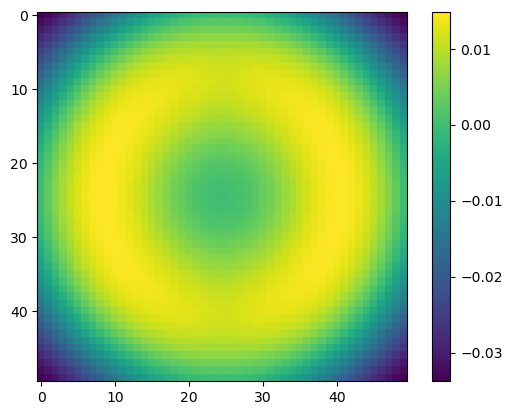

In [10]:
plt.imshow(mass_collision)
plt.colorbar()
plt.show()